# Pregnancy Risk Classification ML Pipeline

This notebook builds a **RandomForest classification model** to predict pregnancy risk levels: **LOW**, **MEDIUM**, or **HIGH**.

## Pipeline Overview:
1. **Data Loading & Exploration** - Load CSV and analyze structure
2. **Data Cleaning** - Remove duplicates and handle missing values
3. **Feature Engineering** - Create BP_diff and BMI categories
4. **Preprocessing** - Scale features and encode target
5. **Model Training** - Train RandomForest and evaluate
6. **Prediction System** - Load model and make predictions on new data

## Key Features Used:
- Age, Systolic BP, Diastolic BP, Blood Sugar, Body Temperature, BMI
- Blood Pressure Difference, Heart Rate, Previous Complications
- Preexisting Diabetes, Gestational Diabetes, Mental Health Issues, BMI Category

## Output:
- Classification report and confusion matrix
- Model saved to `artifacts/` directory
- Prediction function for new patient data

In [13]:
import pandas as pd

df = pd.read_csv("medicalrisk.csv")

print("Rows, cols:", df.shape)
print("\nNull counts:\n", df.isnull().sum())
print("\nColumns:", df.columns.tolist())

print("\nRisk Level value counts:")
print(df['Risk Level'].value_counts(dropna=False))


Rows, cols: (1205, 12)

Null counts:
 Age                        0
Systolic BP                5
Diastolic                  4
BS                         2
Body Temp                  0
BMI                       18
Previous Complications     2
Preexisting Diabetes       2
Gestational Diabetes       0
Mental Health              0
Heart Rate                 2
Risk Level                18
dtype: int64

Columns: ['Age', 'Systolic BP', 'Diastolic', 'BS', 'Body Temp', 'BMI', 'Previous Complications', 'Preexisting Diabetes', 'Gestational Diabetes', 'Mental Health', 'Heart Rate', 'Risk Level']

Risk Level value counts:
Risk Level
Low     713
High    474
NaN      18
Name: count, dtype: int64


In [14]:
dup_mask = df.duplicated(keep=False)
dups = df[dup_mask]

print("Number of exact duplicate rows:", len(dups))
dups.head(20)

Number of exact duplicate rows: 33


,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level
590,30,120.0,75.0,6.8,98,23.0,0.0,0.0,0,0,70.0,Low
592,15,120.0,80.0,6.8,98,23.0,0.0,0.0,0,0,70.0,Low
596,32,120.0,80.0,6.8,98,21.0,0.0,0.0,0,0,70.0,Low
599,23,130.0,70.0,6.8,98,24.0,0.0,0.0,0,0,78.0,Low
612,30,120.0,80.0,6.9,98,20.0,0.0,0.0,0,0,76.0,Low
613,18,120.0,80.0,6.9,98,21.0,0.0,0.0,0,0,76.0,Low
614,17,90.0,60.0,6.9,98,22.0,0.0,0.0,0,0,76.0,Low
615,17,90.0,63.0,6.9,98,23.0,0.0,0.0,0,0,70.0,Low
620,29,130.0,70.0,6.1,98,20.0,0.0,0.0,0,0,78.0,Low
625,31,120.0,60.0,6.1,98,23.0,0.0,0.0,0,0,76.0,Low


In [15]:
feature_cols = [c for c in df.columns if c != 'Risk Level']

dups_feat = df[df.duplicated(subset=feature_cols, keep=False)]
print("Duplicates by feature columns:", len(dups_feat))
dups_feat.head(20)


Duplicates by feature columns: 33


,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level
590,30,120.0,75.0,6.8,98,23.0,0.0,0.0,0,0,70.0,Low
592,15,120.0,80.0,6.8,98,23.0,0.0,0.0,0,0,70.0,Low
596,32,120.0,80.0,6.8,98,21.0,0.0,0.0,0,0,70.0,Low
599,23,130.0,70.0,6.8,98,24.0,0.0,0.0,0,0,78.0,Low
612,30,120.0,80.0,6.9,98,20.0,0.0,0.0,0,0,76.0,Low
613,18,120.0,80.0,6.9,98,21.0,0.0,0.0,0,0,76.0,Low
614,17,90.0,60.0,6.9,98,22.0,0.0,0.0,0,0,76.0,Low
615,17,90.0,63.0,6.9,98,23.0,0.0,0.0,0,0,70.0,Low
620,29,130.0,70.0,6.1,98,20.0,0.0,0.0,0,0,78.0,Low
625,31,120.0,60.0,6.1,98,23.0,0.0,0.0,0,0,76.0,Low


In [16]:
conflicts = dups_feat.groupby(feature_cols)['Risk Level'].nunique()
conflicts = conflicts[conflicts > 1]

print("Number of duplicate groups with conflicting labels:", len(conflicts))
conflicts.head()


Number of duplicate groups with conflicting labels: 0


Series([], Name: Risk Level, dtype: int64)

In [17]:
def fix_duplicates(df):
    feat_cols = [c for c in df.columns if c != 'Risk Level']
    
    rows_to_keep = []
    rows_to_drop = []
    
    for _, group in df.groupby(feat_cols):
        if len(group) == 1:
            rows_to_keep.append(group.index[0])
        else:
            labels = group['Risk Level'].unique()
            if len(labels) == 1:
                rows_to_keep.append(group.index[0])
            else:
                # conflicting labels → drop
                rows_to_drop.extend(group.index.tolist())
    
    cleaned = df.loc[rows_to_keep].copy()
    print(f"Dropped {len(rows_to_drop)} conflicting duplicate rows.")
    return cleaned

df_clean = df.dropna(subset=['Risk Level']).copy()
df_clean = fix_duplicates(df_clean)

print("Rows after fixing duplicates:", df_clean.shape)


Dropped 0 conflicting duplicate rows.
Rows after fixing duplicates: (1148, 12)


In [18]:
numeric_cols = [
    'Age','Systolic BP','Diastolic','BS','Body Temp','BMI',
    'Previous Complications','Preexisting Diabetes',
    'Gestational Diabetes','Mental Health','Heart Rate'
]

for col in numeric_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

df_clean.isnull().sum()



Age                       0
Systolic BP               0
Diastolic                 0
BS                        0
Body Temp                 0
BMI                       0
Previous Complications    0
Preexisting Diabetes      0
Gestational Diabetes      0
Mental Health             0
Heart Rate                0
Risk Level                0
dtype: int64

In [19]:
df_clean['BP_diff'] = df_clean['Systolic BP'] - df_clean['Diastolic']

bmi_cat = pd.cut(df_clean['BMI'],
                 bins=[0,18.5,24.9,29.9,100],
                 labels=[0,1,2,3])

df_clean['BMI_cat'] = bmi_cat.cat.codes.replace(-1, 1).astype(int)

df_clean.head()


,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level,BP_diff,BMI_cat
750,10,100.0,50.0,6.0,99,18.9,0.0,0.0,0,0,70.0,Low,50.0,1
835,12,90.0,60.0,3.0,102,21.0,0.0,0.0,0,0,66.0,Low,30.0,1
841,12,90.0,60.0,3.7,102,21.0,0.0,0.0,0,0,60.0,Low,30.0,1
728,12,90.0,60.0,6.5,102,22.0,0.0,0.0,0,0,66.0,Low,30.0,1
664,12,95.0,60.0,6.9,98,22.0,0.0,0.0,0,0,65.0,Low,35.0,1


In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_clean['target'] = le.fit_transform(df_clean['Risk Level'])

print("Classes:", le.classes_)
print(df_clean['target'].value_counts())


Classes: ['High' 'Low']
target
1    685
0    463
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib
import os

features = [
    'Age','Systolic BP','Diastolic','BS','Body Temp','BMI',
    'BP_diff','Heart Rate','Previous Complications','Preexisting Diabetes',
    'Gestational Diabetes','Mental Health','BMI_cat'
]

X = df_clean[features]
y = df_clean['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Scale features
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# Train RandomForest
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train_s, y_train)

# Make predictions
y_pred = model.predict(X_test_s)

# Evaluate model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("="*70)
print("📊 MODEL PERFORMANCE METRICS")
print("="*70)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save artifacts to directory
os.makedirs("artifacts", exist_ok=True)
joblib.dump(model, "artifacts/pregnancy_risk_model.pkl")
joblib.dump(scaler, "artifacts/scaler.pkl")
joblib.dump(le, "artifacts/label_encoder.pkl")

print("\n✅ Model and artifacts saved to artifacts/ directory!")

Model saved successfully!


In [24]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_idx, val_idx in cv.split(X, y):
    Xtr, Xval = X.iloc[train_idx], X.iloc[val_idx]
    ytr, yval = y.iloc[train_idx], y.iloc[val_idx]
    
    sc = StandardScaler().fit(Xtr)
    m = RandomForestClassifier(n_estimators=200, random_state=42)
    
    m.fit(sc.transform(Xtr), ytr)
    scores.append(m.score(sc.transform(Xval), yval))

print("CV scores:", scores)
print("Mean:", np.mean(scores), "Std:", np.std(scores))


CV scores: [0.9869565217391304, 0.9869565217391304, 0.9956521739130435, 0.9868995633187773, 0.9956331877729258]
Mean: 0.9904195936966014 Std: 0.004264687738633029


In [25]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

df = pd.read_csv("medicalrisk.csv")
df = df.dropna(subset=["Risk Level"]).copy()   # remove rows without target

# Create folder for plots
plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)

print("Data loaded:", df.shape)
df.head()


Data loaded: (1187, 12)


,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level
0,22,90.0,60.0,9.0,100,18.0,1.0,1.0,0,1,80.0,High
1,22,110.0,70.0,7.1,98,20.4,0.0,0.0,0,0,74.0,Low
2,27,110.0,70.0,7.5,98,23.0,1.0,0.0,0,0,72.0,Low
3,20,100.0,70.0,7.2,98,21.2,0.0,0.0,0,0,74.0,Low
4,20,90.0,60.0,7.5,98,19.7,0.0,0.0,0,0,74.0,Low


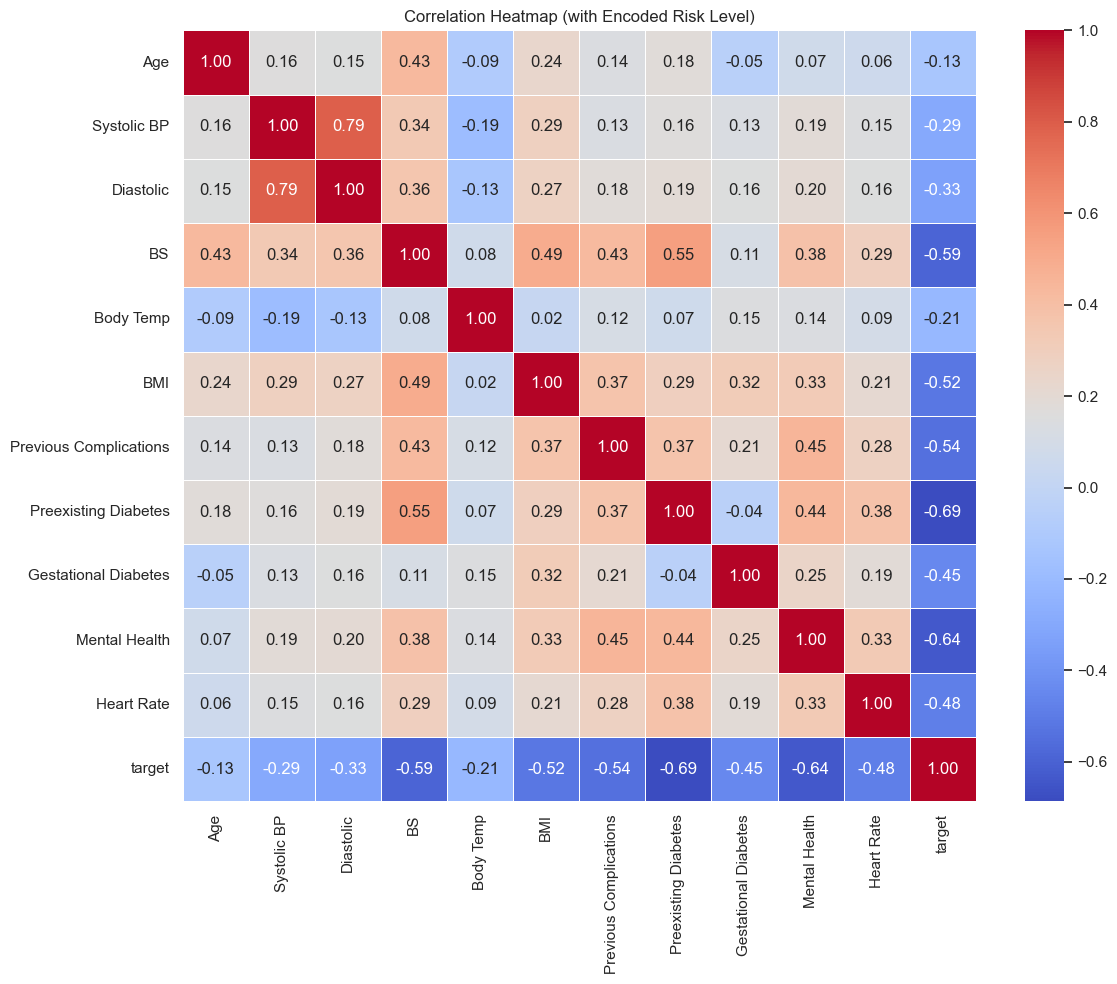

In [26]:
from sklearn.preprocessing import LabelEncoder

# Encode target for correlation
le = LabelEncoder()
df["target"] = le.fit_transform(df["Risk Level"])

# Select numeric columns + target
corr_cols = [
    "Age", "Systolic BP", "Diastolic", "BS", "Body Temp", "BMI",
    "Previous Complications", "Preexisting Diabetes",
    "Gestational Diabetes", "Mental Health", "Heart Rate", "target"
]

corr = df[corr_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap (with Encoded Risk Level)")
plt.tight_layout()
plt.savefig(plots_dir / "correlation_heatmap.png", dpi=150)
plt.show()


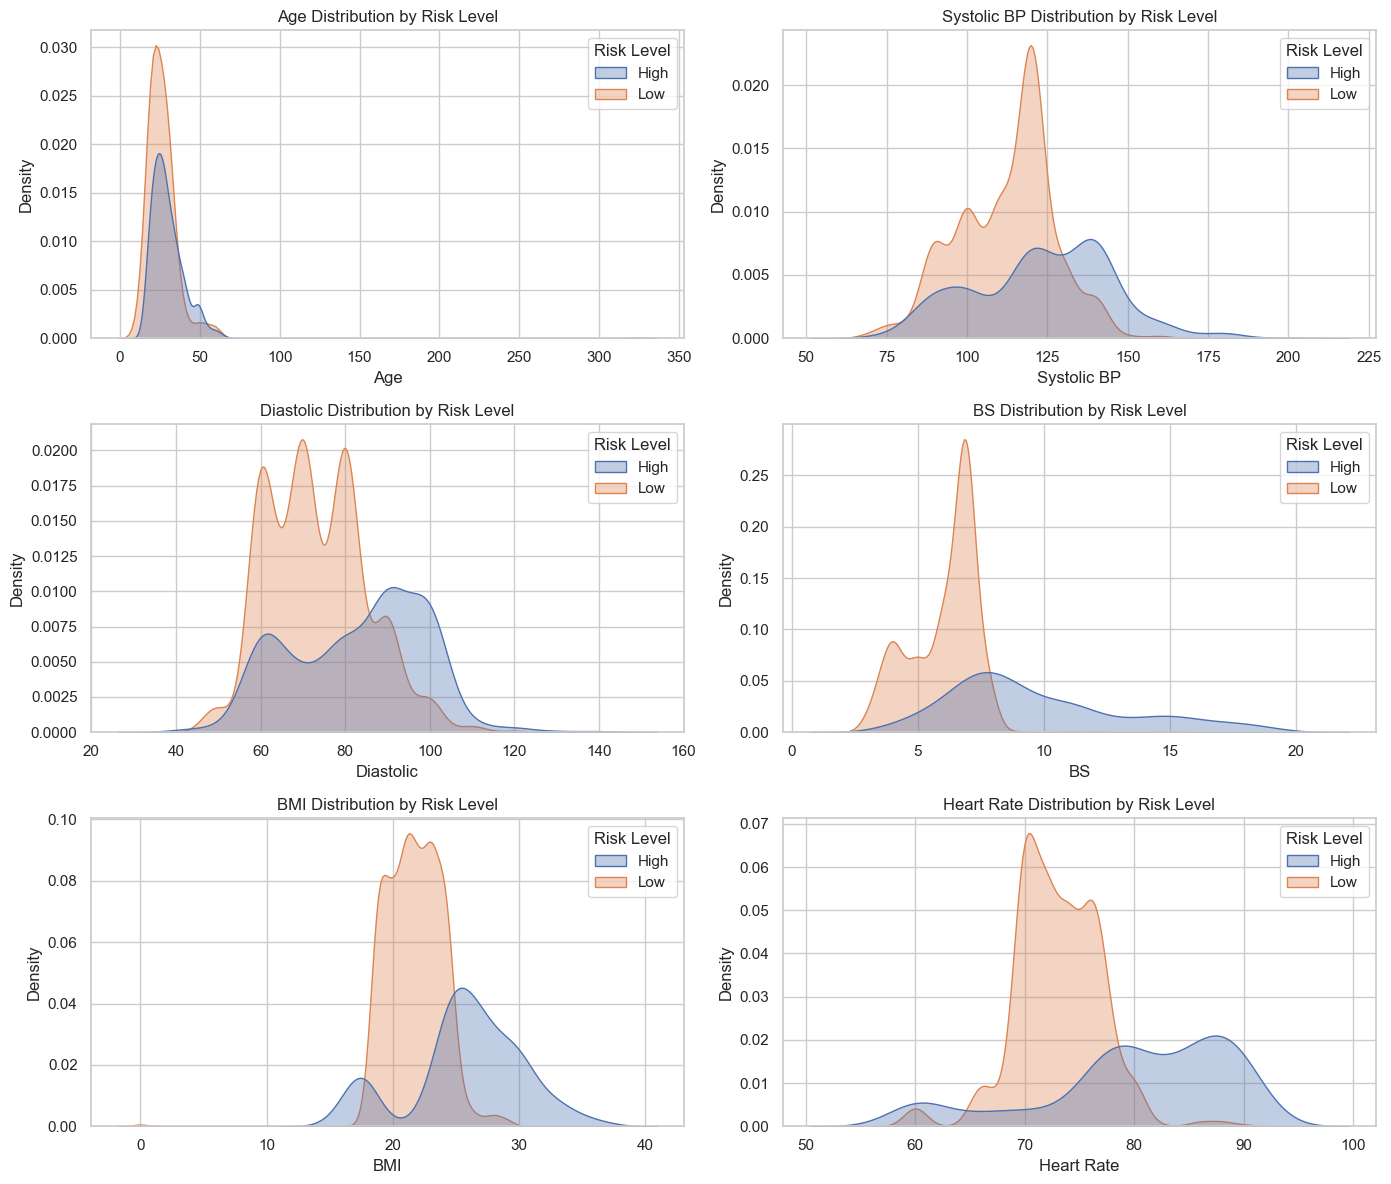

In [27]:
features = ["Age","Systolic BP","Diastolic","BS","BMI","Heart Rate"]

plt.figure(figsize=(14, 12))
for i, col in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(data=df, x=col, hue="Risk Level", fill=True, alpha=0.35)
    plt.title(f"{col} Distribution by Risk Level")

plt.tight_layout()
plt.savefig(plots_dir / "kde_distributions.png", dpi=150)
plt.show()


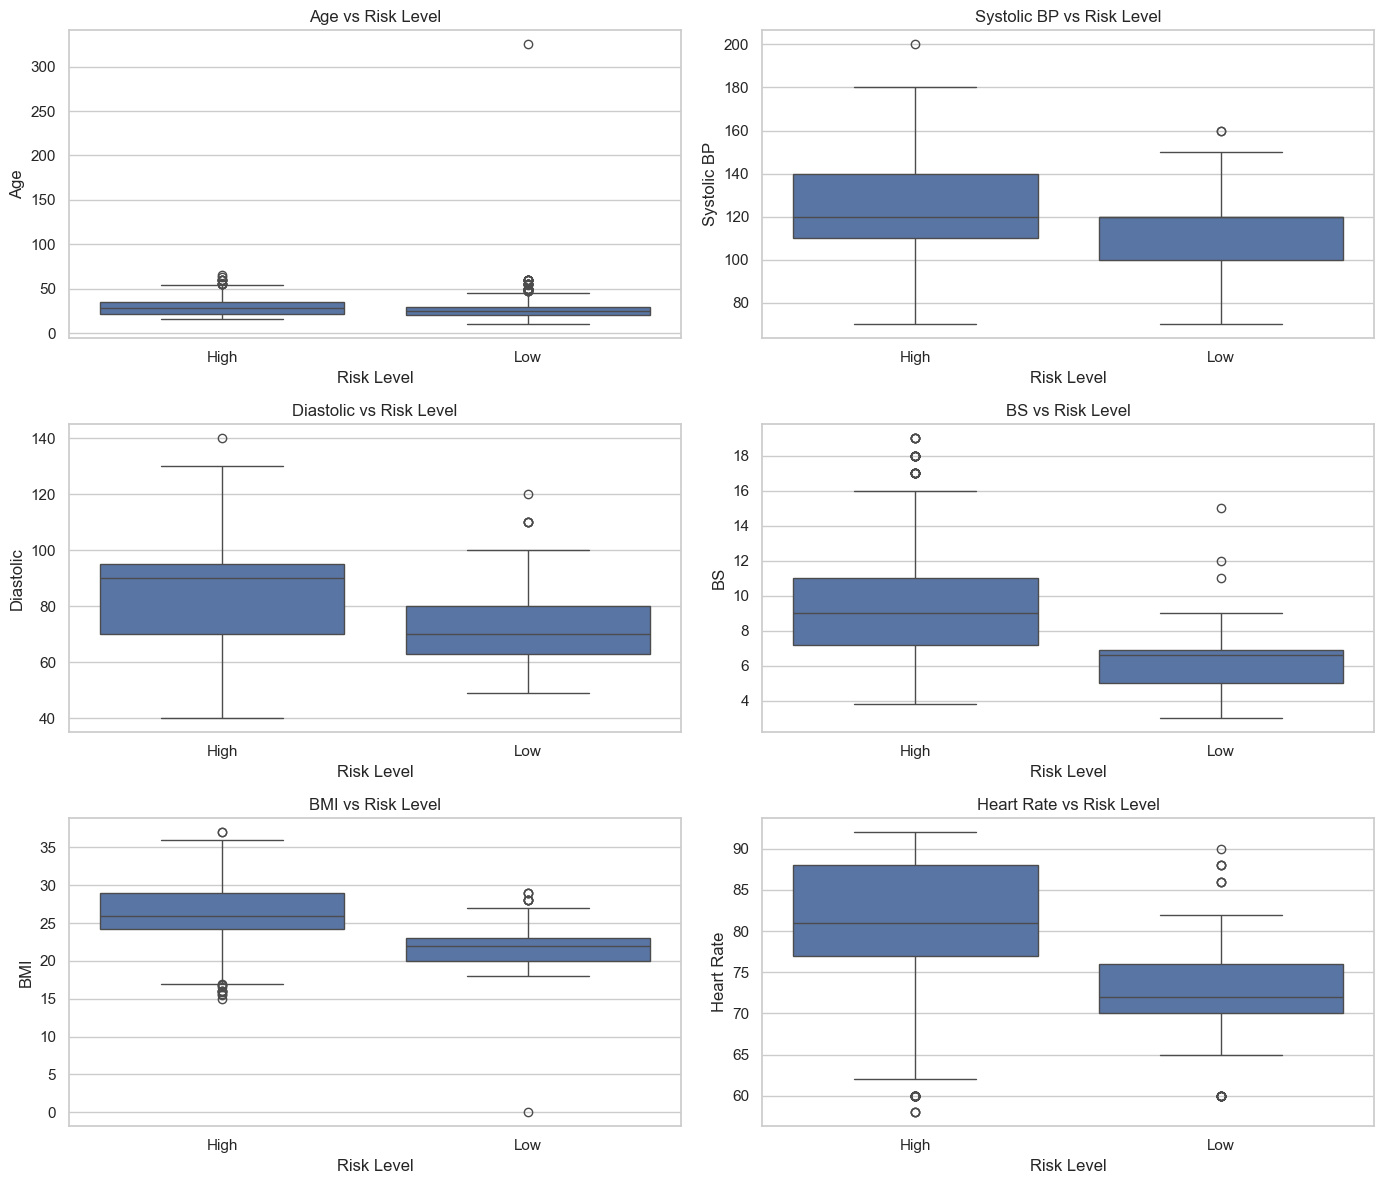

In [28]:
plt.figure(figsize=(14, 12))
for i, col in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x="Risk Level", y=col)
    plt.title(f"{col} vs Risk Level")

plt.tight_layout()
plt.savefig(plots_dir / "boxplots_risk.png", dpi=150)
plt.show()


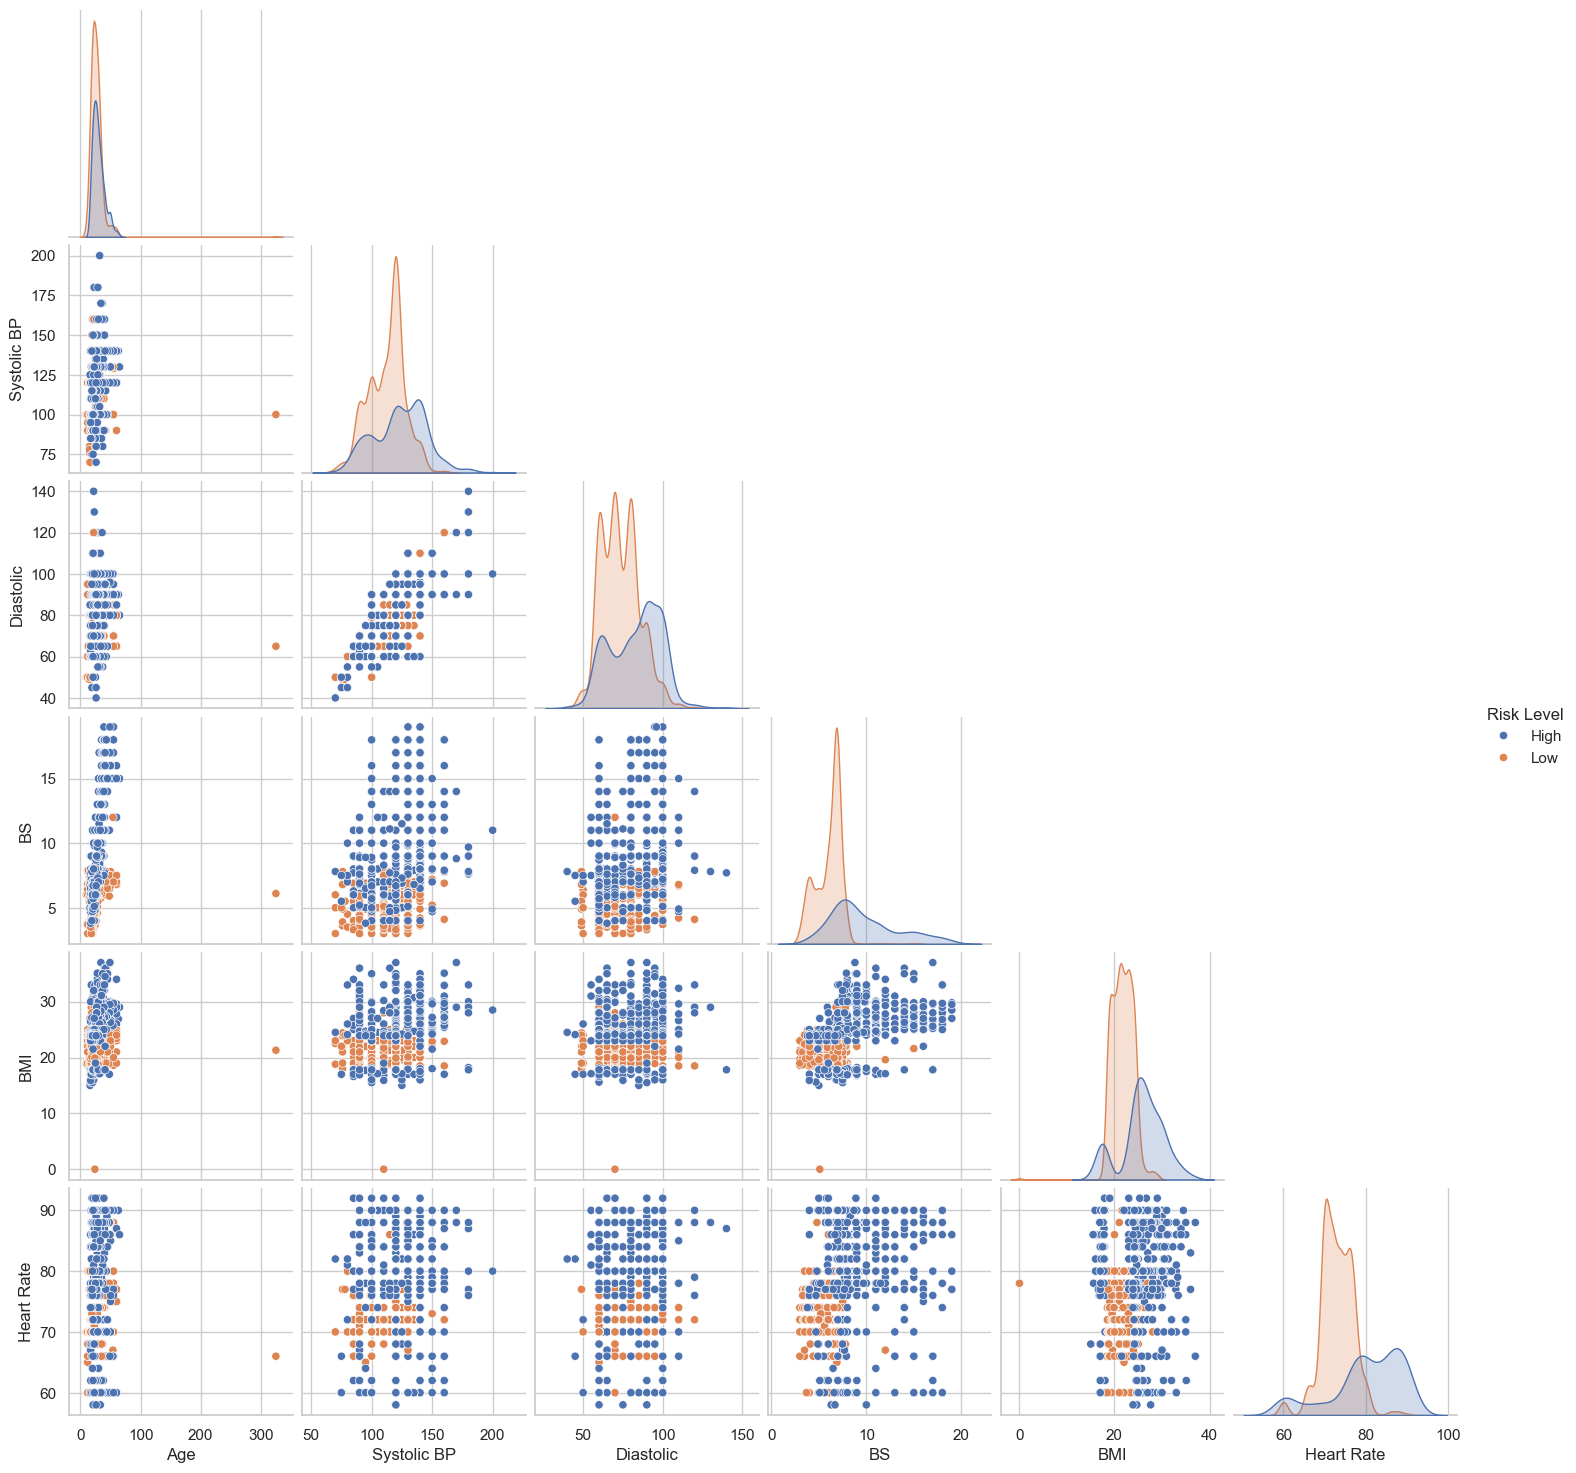

In [29]:
sns.pairplot(
    df[["Age","Systolic BP","Diastolic","BS","BMI","Heart Rate","Risk Level"]],
    hue="Risk Level",
    diag_kind="kde",
    corner=True
)
plt.savefig(plots_dir / "pairplot.png", dpi=150)
plt.show()


In [ ]:
import joblib
import numpy as np

# Load model artifacts
model = joblib.load("pregnancy_risk_model.pkl")
scaler = joblib.load("scaler.pkl")
le = joblib.load("label_encoder.pkl")


def predict_pregnancy_risk(age, sbp, dbp, bs, temp, bmi, prev_comp, pre_diab, ges_diab, mental, hr):
    """
    Predict pregnancy risk level.
    
    Parameters:
    - age: Age in years
    - sbp: Systolic Blood Pressure
    - dbp: Diastolic Blood Pressure
    - bs: Blood Sugar level
    - temp: Body Temperature
    - bmi: Body Mass Index
    - prev_comp: Previous Complications (0 or 1)
    - pre_diab: Preexisting Diabetes (0 or 1)
    - ges_diab: Gestational Diabetes (0 or 1)
    - mental: Mental Health issues (0 or 1)
    - hr: Heart Rate
    
    Returns:
    - risk_level: 'low risk', 'medium risk', or 'high risk'
    - confidence: Probability of prediction (0-1)
    """
    # Feature engineering
    bp_diff = sbp - dbp
    
    # BMI category
    if bmi < 18.5:
        bmi_cat = 0
    elif bmi < 25:
        bmi_cat = 1
    elif bmi < 30:
        bmi_cat = 2
    else:
        bmi_cat = 3

    # Create feature vector (must match training order)
    X_input = np.array([[age, sbp, dbp, bs, temp, bmi,
                         bp_diff, hr, prev_comp, pre_diab,
                         ges_diab, mental, bmi_cat]])

    # Scale features
    X_scaled = scaler.transform(X_input)

    # Predict
    pred_index = model.predict(X_scaled)[0]
    risk_level = le.inverse_transform([pred_index])[0]
    confidence = model.predict_proba(X_scaled).max()

    return risk_level, round(float(confidence), 4)


print("="*70)
print("🤰 PREGNANCY RISK PREDICTION SYSTEM")
print("="*70)

# Test Case 1: LOW RISK
print("\n🟢 TEST CASE 1: LOW RISK PATIENT")
print("-" * 70)
low_risk_pred, low_risk_conf = predict_pregnancy_risk(
    age=23,           # Young
    sbp=118,          # Normal BP
    dbp=75,           # Normal BP
    bs=6.3,           # Normal blood sugar
    temp=98.4,        # Normal temperature
    bmi=22.5,         # Healthy BMI
    prev_comp=0,      # No previous complications
    pre_diab=0,       # No diabetes
    ges_diab=0,       # No gestational diabetes
    mental=0,         # No mental health issues
    hr=78             # Normal heart rate
)
print(f"Prediction: {low_risk_pred.upper()}")
print(f"Confidence: {low_risk_conf * 100:.2f}%")

# Test Case 2: MEDIUM RISK
print("\n🟡 TEST CASE 2: MEDIUM RISK PATIENT")
print("-" * 70)
medium_risk_pred, medium_risk_conf = predict_pregnancy_risk(
    age=29,           # Mid-age
    sbp=135,          # Slightly elevated BP
    dbp=85,           # Slightly elevated BP
    bs=7.8,           # Slightly elevated blood sugar
    temp=98.9,        # Normal-high temperature
    bmi=27.5,         # Overweight
    prev_comp=0,      # No previous complications
    pre_diab=0,       # No diabetes
    ges_diab=1,       # Has gestational diabetes
    mental=0,         # No mental health issues
    hr=92             # Elevated heart rate
)
print(f"Prediction: {medium_risk_pred.upper()}")
print(f"Confidence: {medium_risk_conf * 100:.2f}%")

# Test Case 3: HIGH RISK
print("\n🔴 TEST CASE 3: HIGH RISK PATIENT")
print("-" * 70)
high_risk_pred, high_risk_conf = predict_pregnancy_risk(
    age=34,           # Older age
    sbp=160,          # High BP
    dbp=100,          # High BP
    bs=9.4,           # High blood sugar
    temp=99.1,        # High temperature
    bmi=34.0,         # Obese
    prev_comp=1,      # Has previous complications
    pre_diab=1,       # Has diabetes
    ges_diab=1,       # Has gestational diabetes
    mental=1,         # Has mental health issues
    hr=115            # High heart rate
)
print(f"Prediction: {high_risk_pred.upper()}")
print(f"Confidence: {high_risk_conf * 100:.2f}%")

print("\n" + "="*70)
print("✅ Prediction Complete!")
print("="*70)